# Jores et al 2021 Plotting 
**Authorship:**
Adam Klie, *09/12/2022*
***
**Description:**
Notebook to generate plots for the Jores et al (2021) dataset that are not included in the other notebooks.
 - Summary table of benchmarking results for for each model type
 - Cleaner seq track plots for top sequences
 - TomTom filter annotation analysis
 - Loss and metric plots
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt
import matplotlib

# For illustrator editing
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [2]:
# Configure directories
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/jores21"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/jores21"
eu.settings.figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/jores21"

# Generate performance figures

## Leaf models

In [3]:
# Read in the predictions 
sdata_leaf = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, "leaf_test_predictions.h5sd"))

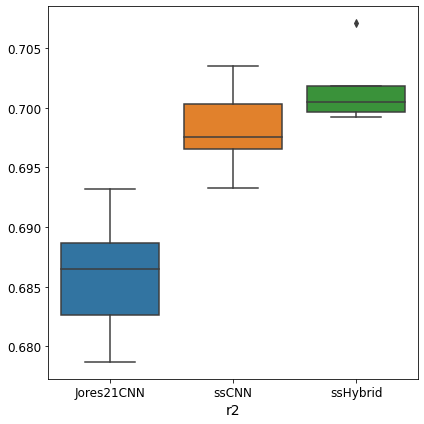

<Figure size 432x288 with 0 Axes>

In [4]:
# Summarize performance across models for r2
leaf_model_scores = eu.pl.performance_summary(
    sdata_leaf,
    target="enrichment",
    prediction_groups=["Jores21CNN"]*5 + ["ssCNN"]*5 + ["ssHybrid"]*5,
    metrics=["r2"],
    add_swarm=False,
    figsize=(6, 6),
    save=os.path.join(eu.settings.figure_dir, "leaf_performance_boxplot.pdf")
)

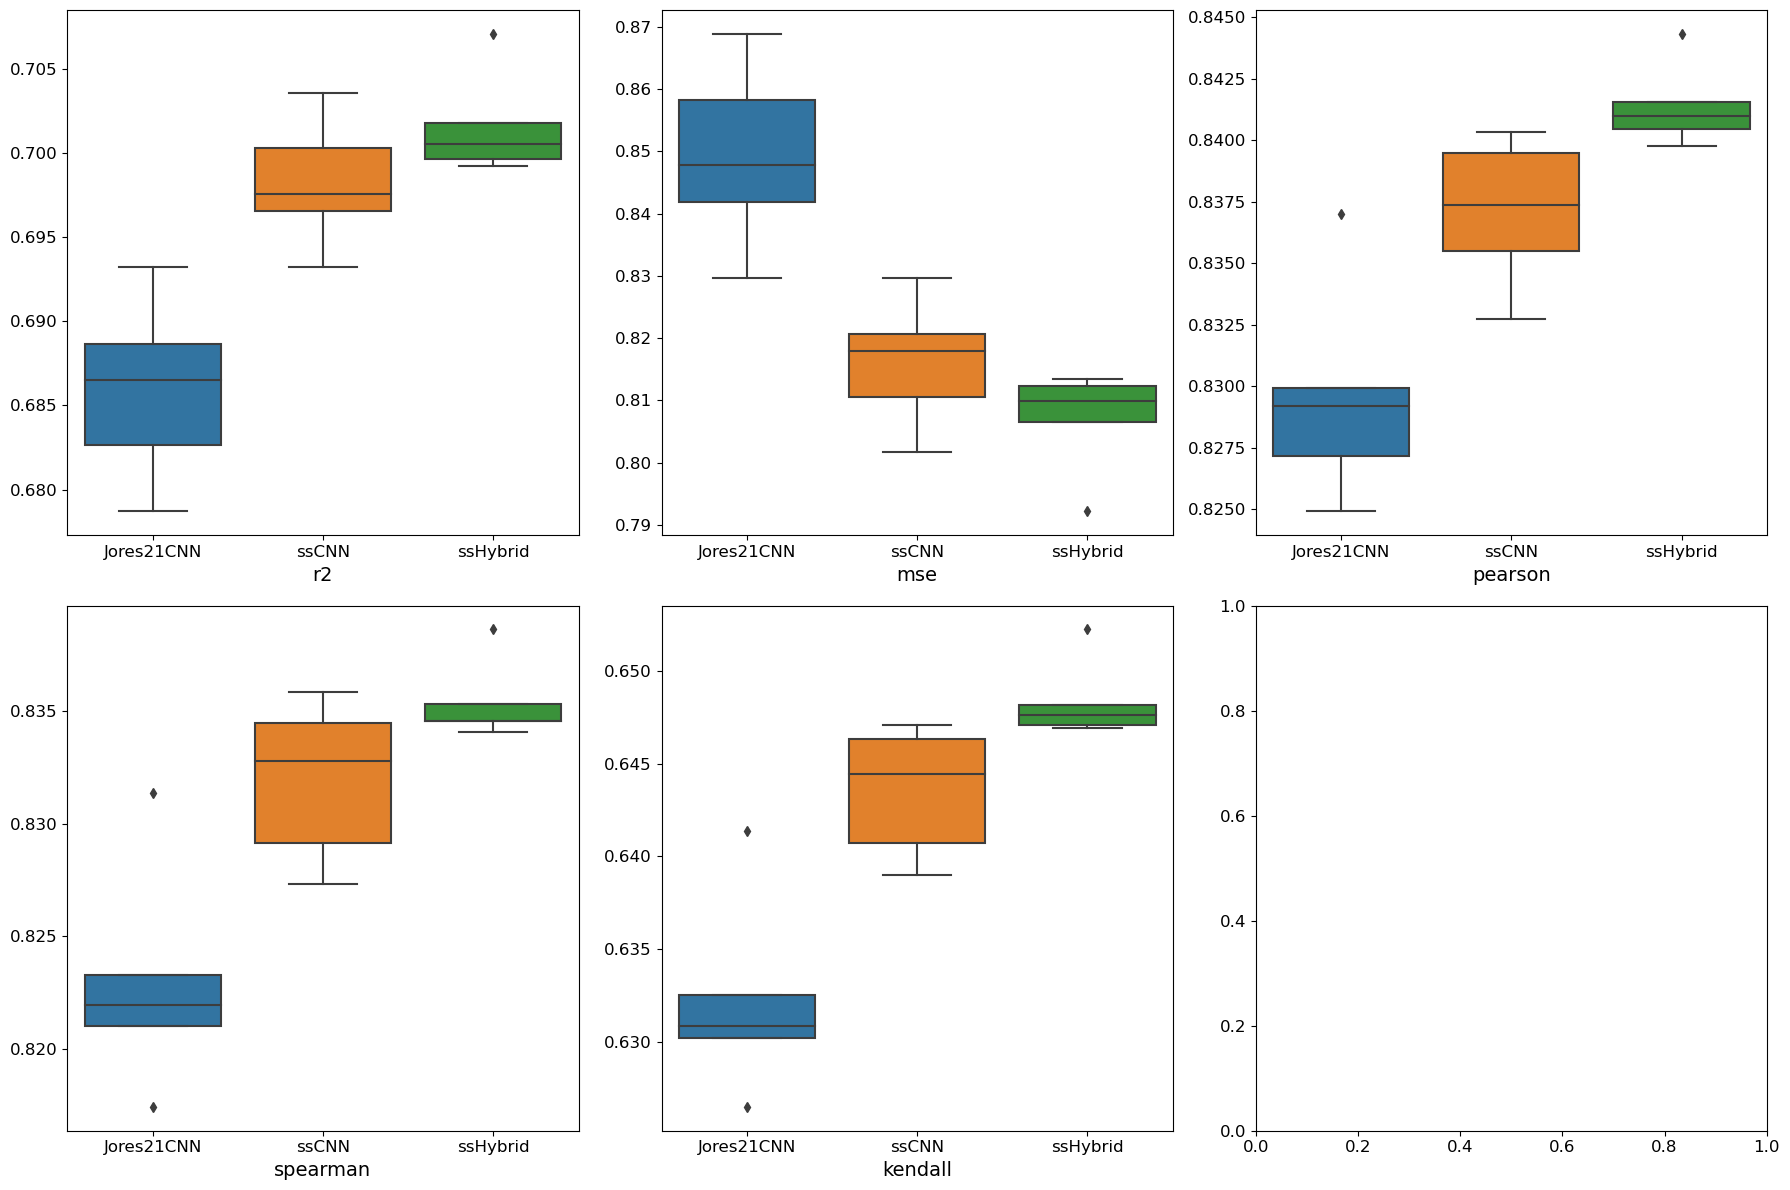

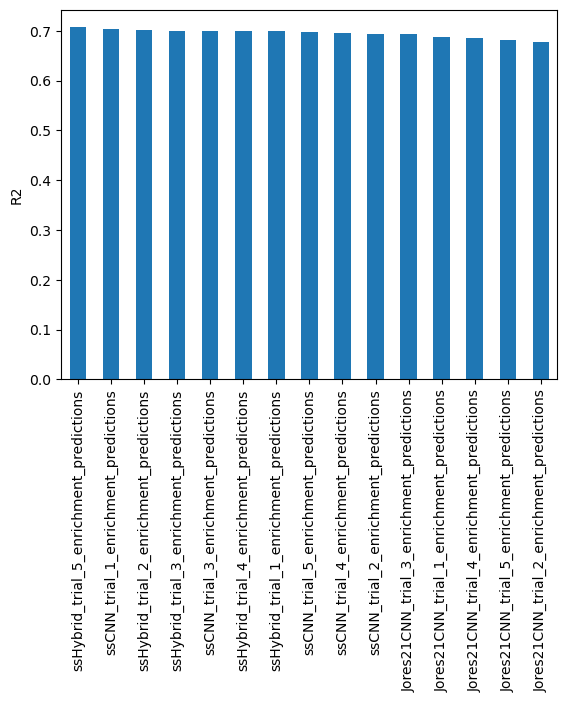

In [5]:
# Summarize performance across models for multiple metrics
leaf_model_scores = eu.pl.performance_summary(
    sdata_leaf,
    target="enrichment",
    prediction_groups=["Jores21CNN"]*5 + ["ssCNN"]*5 + ["ssHybrid"]*5,
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    add_swarm=False,
    figsize=(6, 6),
)

# Identify the best model from returned model scores
r2_sorted = leaf_model_scores["r2"].sort_values(ascending=False)
r2_sorted.plot(kind="bar", ylabel="R2")
plt.savefig(os.path.join(eu.settings.figure_dir, "leaf_performance_summary.pdf"))

In [6]:
# Save the performance summary as a table
leaf_model_scores.to_csv(os.path.join(eu.settings.output_dir, "leaf_performance_summary.tsv"), sep="\t")

Group R2 MSE Spearmanr
At 0.5164099190409797 0.6735613405589178 0.7046093358911515
Sb 0.66927878113486 0.8979140299942686 0.8363478785599603
Zm 0.7465031255417363 0.7718591023794221 0.8672154866420015


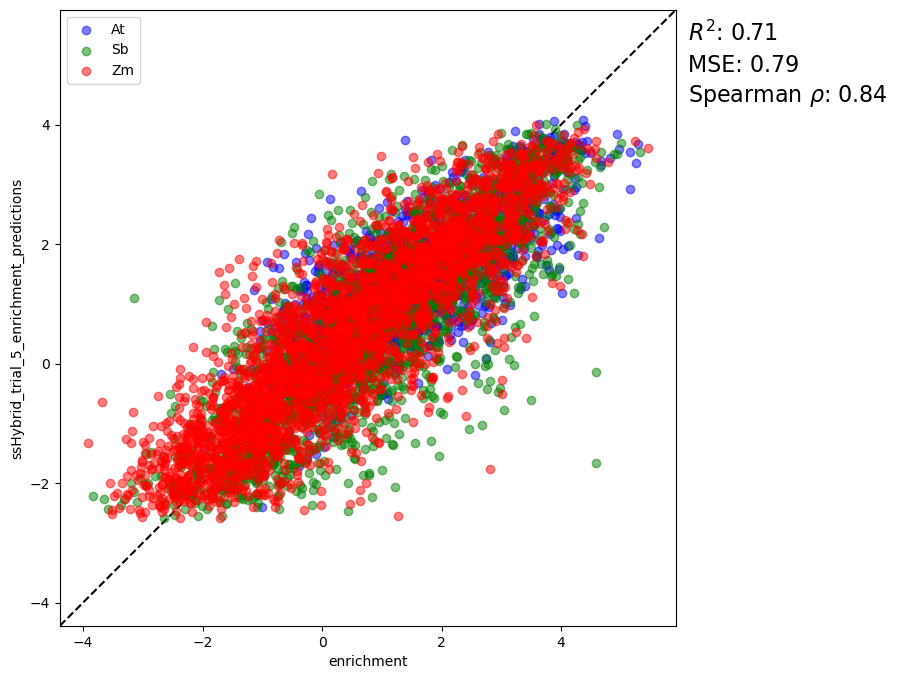

In [7]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = eu.pl.performance_scatter(
    sdata_leaf, 
    targets="enrichment", 
    predictions=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(eu.settings.figure_dir, "leaf_best_model_performance_scatter_by_sp.pdf")
)

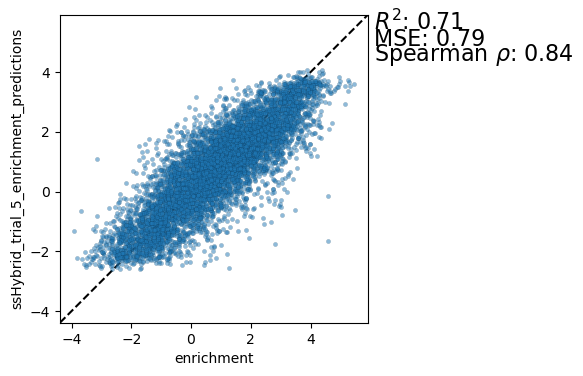

In [8]:
# Plot the performance for all species to use in Figure 2 
ax = eu.pl.performance_scatter(
    sdata_leaf, 
    targets="enrichment", 
    predictions=best_preds,
    alpha=0.5,
    figsize=(4, 4),
    rasterized=True,
    save=os.path.join(eu.settings.figure_dir, "leaf_best_model_performance_scatter.pdf")
)

## Proto models

In [9]:
# Read in if already made predictions and generated file above
sdata_proto = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, "proto_test_predictions.h5sd"))

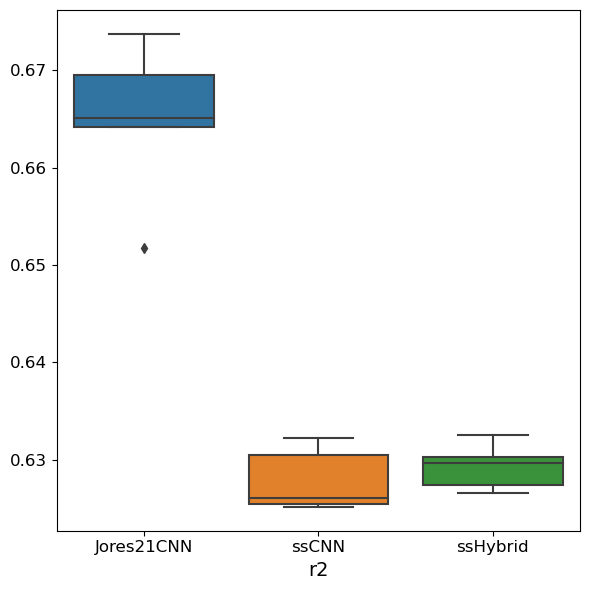

<Figure size 640x480 with 0 Axes>

In [10]:
# Summarize performance across models for r2
proto_model_scores = eu.pl.performance_summary(
    sdata_proto,
    target="enrichment",
    prediction_groups=["Jores21CNN"]*5 + ["ssCNN"]*5 + ["ssHybrid"]*5,
    metrics=["r2"],
    add_swarm=False,
    figsize=(6, 6),
    save=os.path.join(eu.settings.figure_dir, "proto_performance_boxplot.pdf")
)

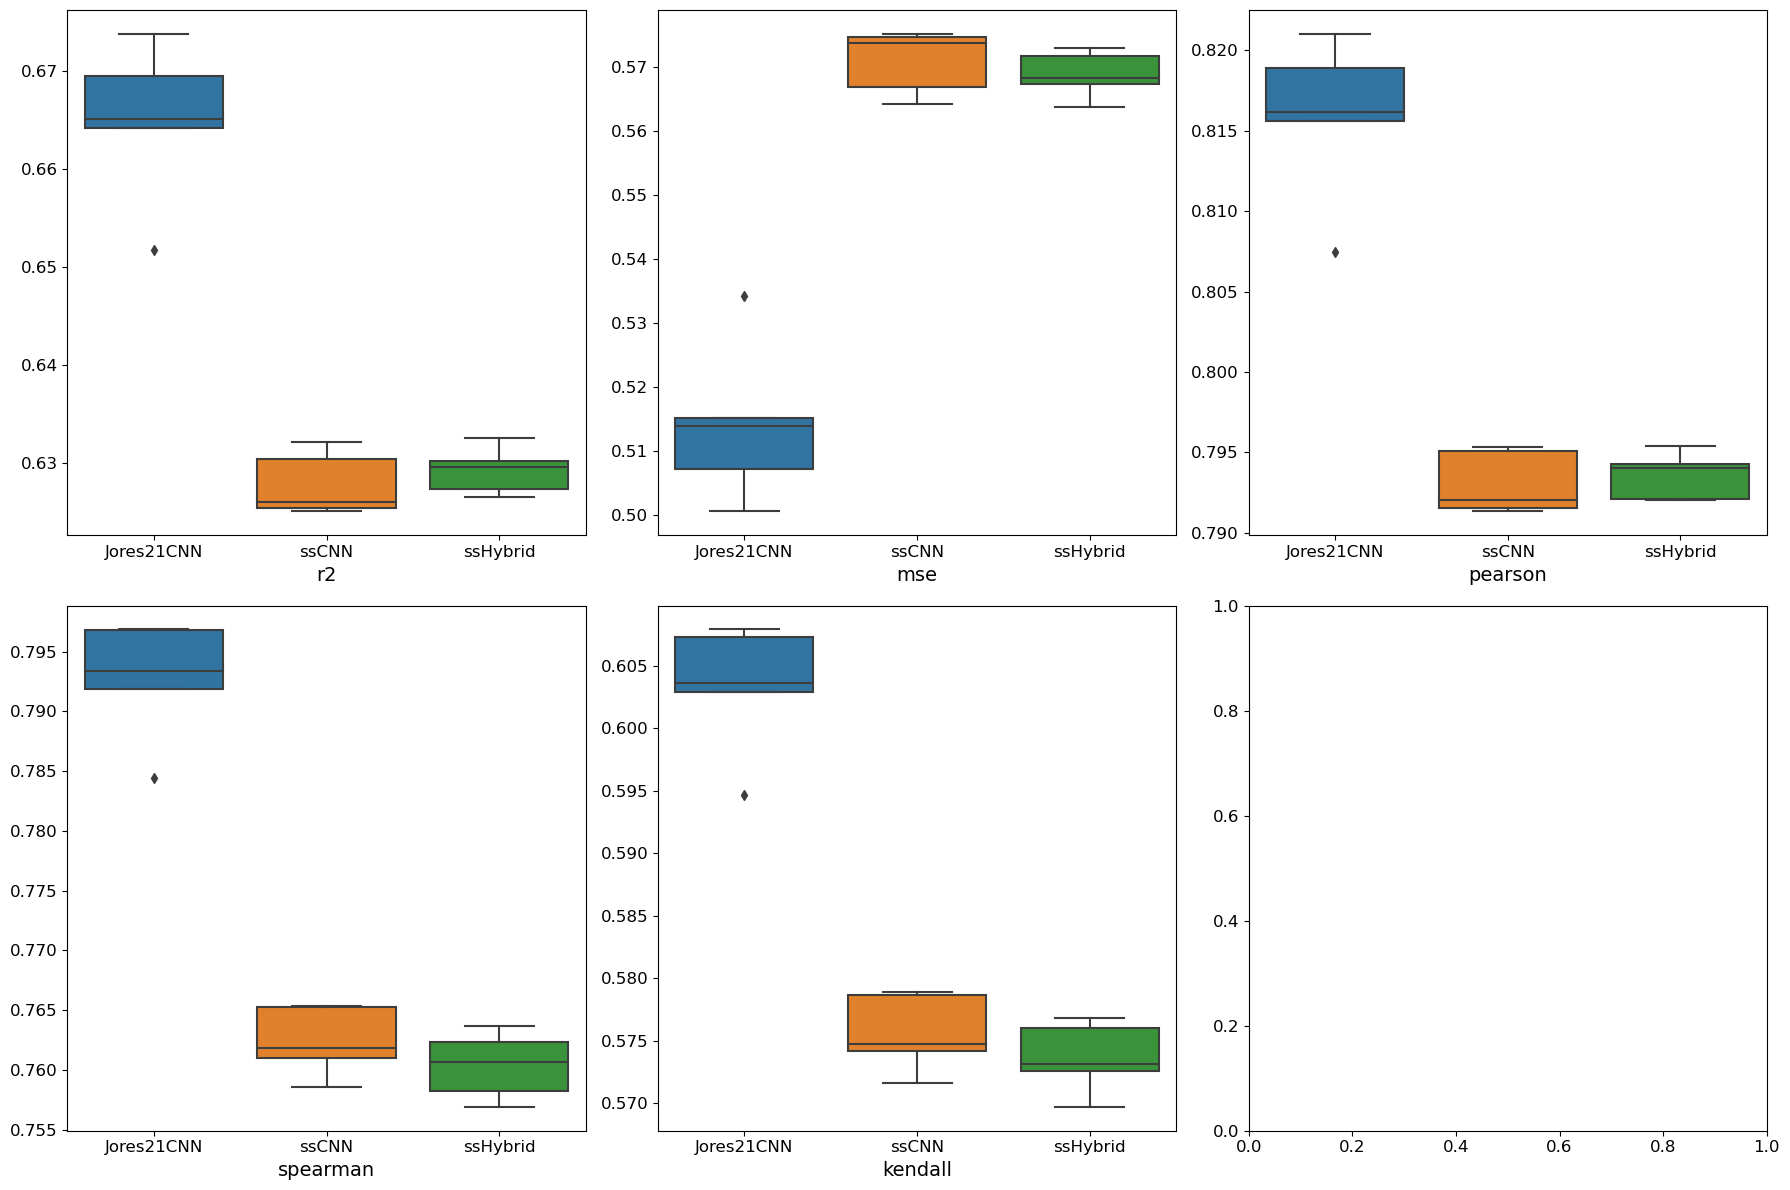

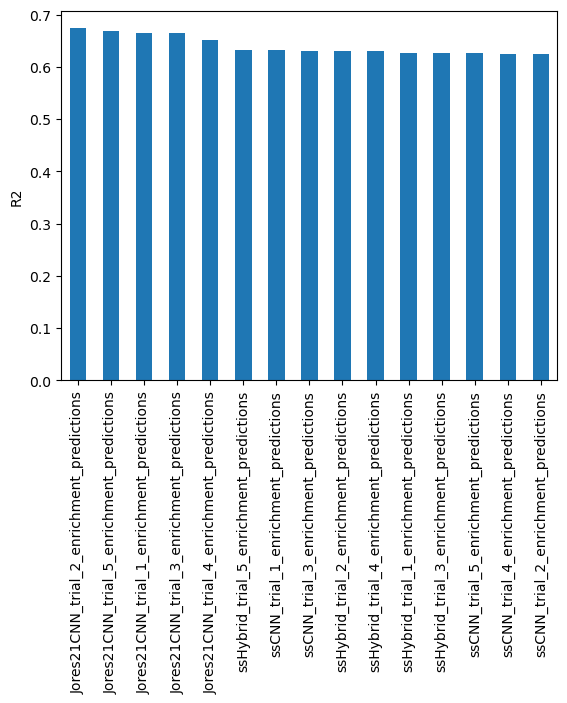

In [11]:
# Summarize performance across models for a metric
proto_model_scores = eu.pl.performance_summary(
    sdata_proto,
    target="enrichment",
    prediction_groups=["Jores21CNN"]*5 + ["ssCNN"]*5 + ["ssHybrid"]*5,
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    add_swarm=False,
    figsize=(6, 6),
)

# Identify the best model from returned model scores
r2_sorted = proto_model_scores["r2"].sort_values(ascending=False)
r2_sorted.plot(kind="bar", ylabel="R2")
plt.savefig(os.path.join(eu.settings.figure_dir, "proto_performance_summary.pdf"))

Group R2 MSE Spearmanr
At 0.5514243013895882 0.6476637872909053 0.7372850748322327
Sb 0.6106554247981983 0.488565439478022 0.7572806525870309
Zm 0.6897345973090998 0.43401701350725963 0.8171762409955199


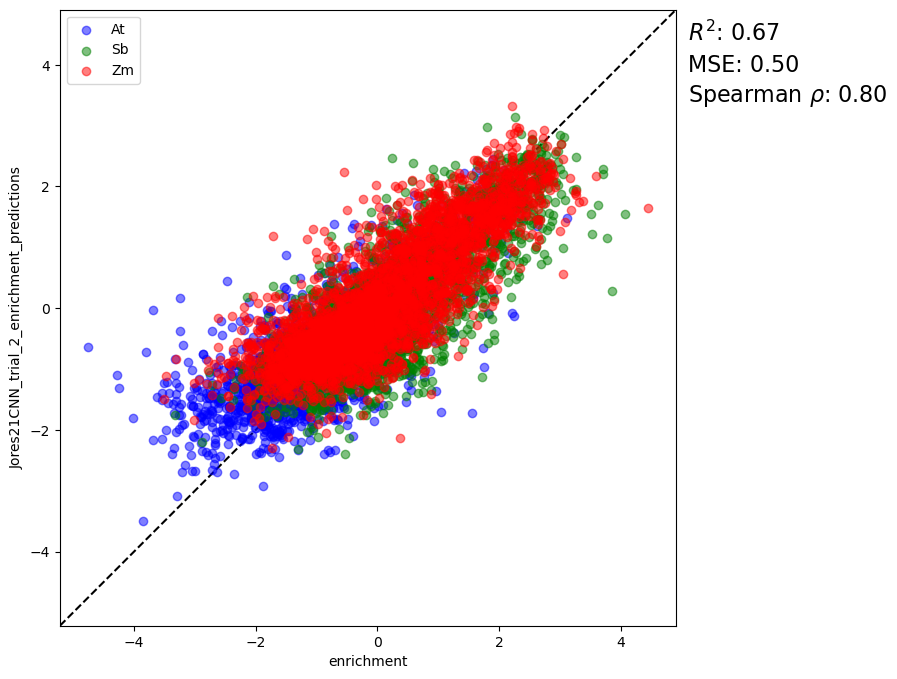

In [12]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = eu.pl.performance_scatter(
    sdata_proto, 
    targets="enrichment", 
    predictions=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(eu.settings.figure_dir, "proto_best_model_performance_scatter_by_sp.pdf")
)

In [13]:
# Save the performance summary as a table
proto_model_scores.to_csv(os.path.join(eu.settings.output_dir, "proto_performance_summary.tsv"), sep="\t")

## Combined models

In [14]:
# Read in if already made predictions and generated file above
sdata_combined = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, "combined_test_predictions.h5sd"))

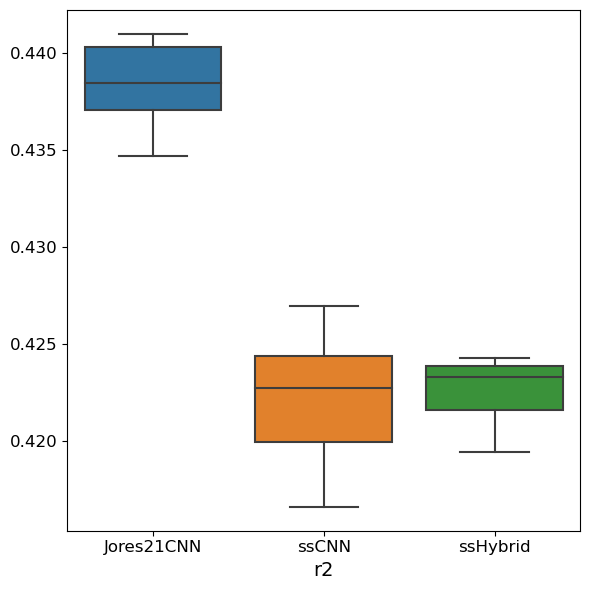

<Figure size 640x480 with 0 Axes>

In [15]:
# Summarize performance across models for a metric
model_scores = eu.pl.performance_summary(
    sdata_combined,
    target="enrichment",
    prediction_groups=["Jores21CNN"]*5 + ["ssCNN"]*5 + ["ssHybrid"]*5,
    metrics=["r2"],
    add_swarm=False,
    figsize=(6, 6),
    save= os.path.join(eu.settings.figure_dir, "combined_performance_boxplot.pdf")
)

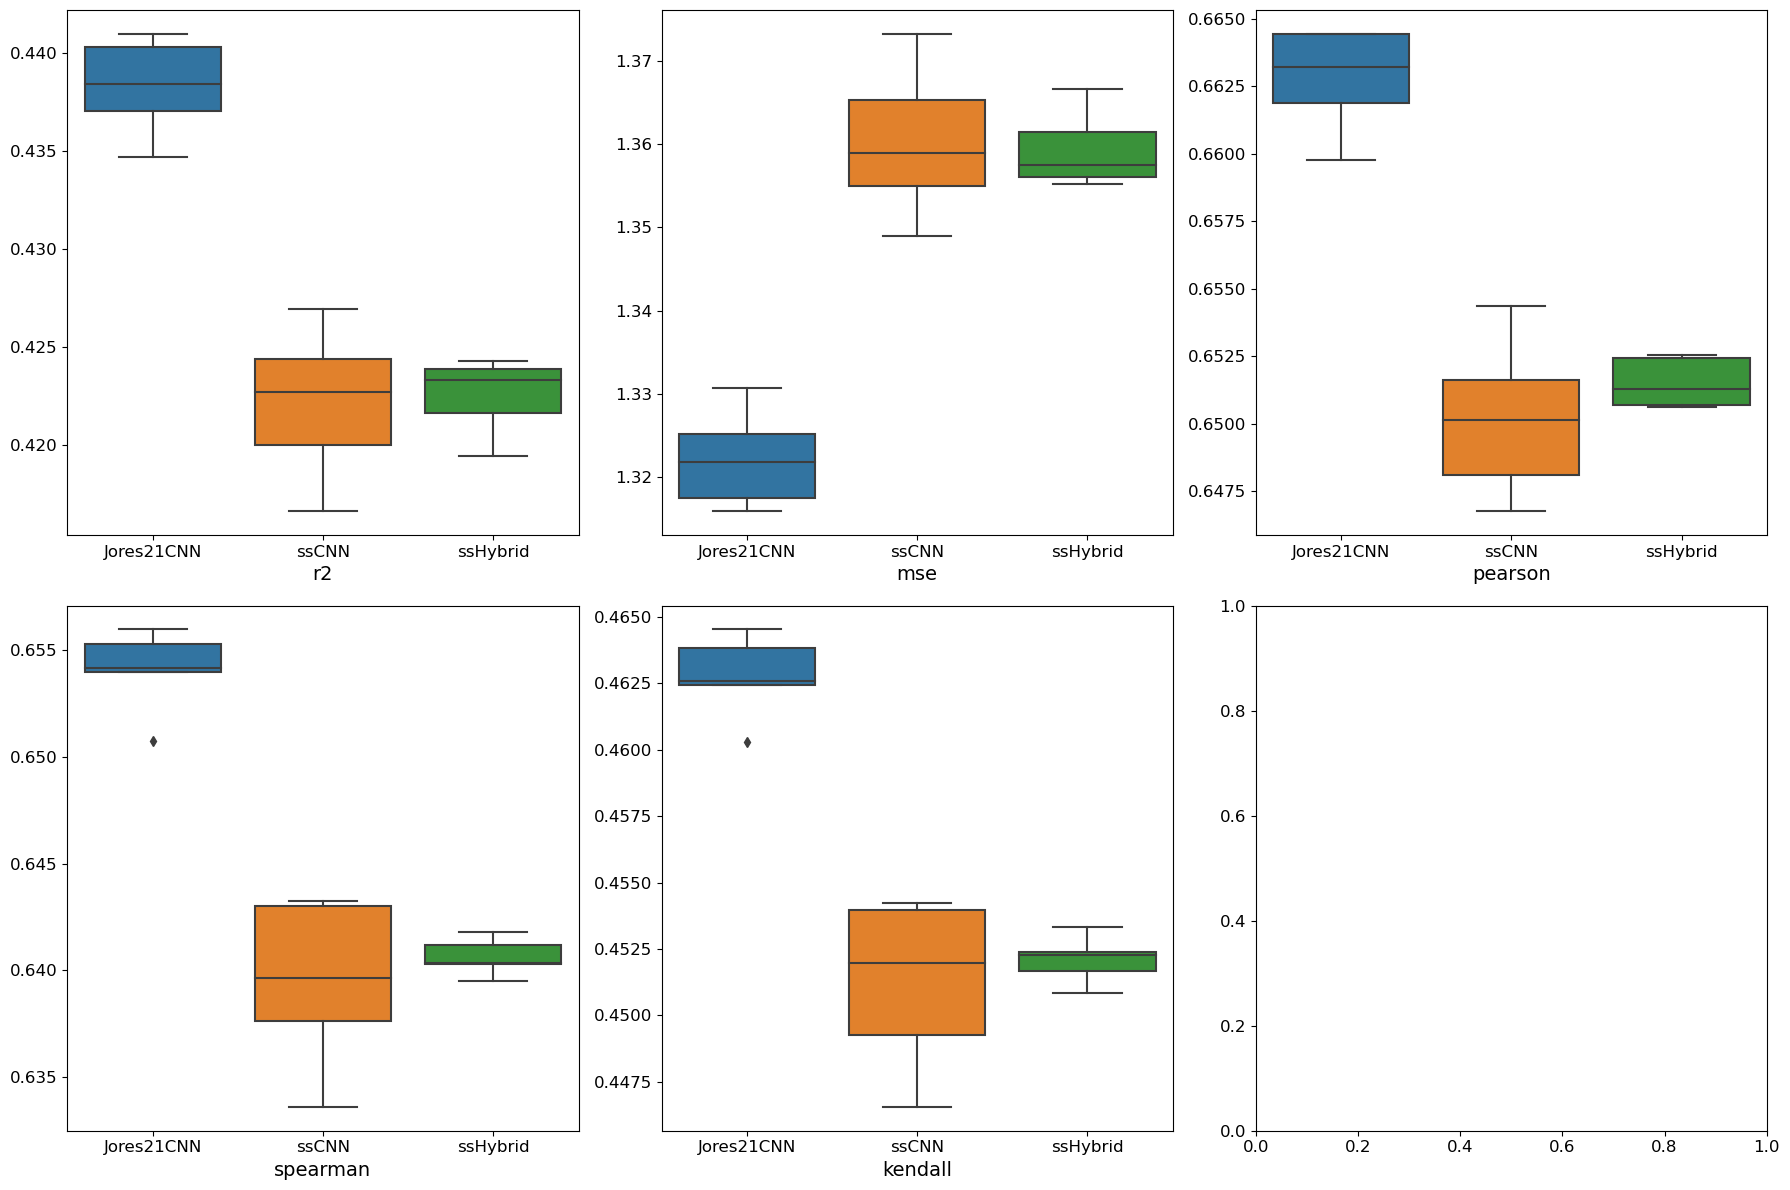

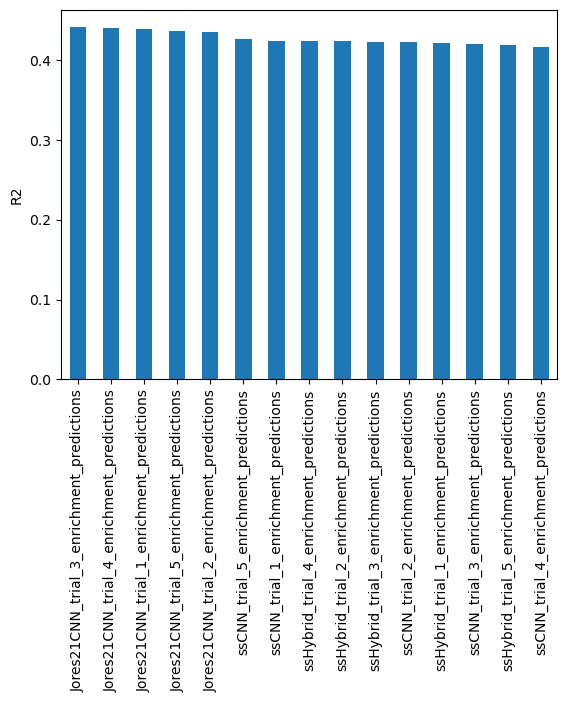

In [16]:
# Summarize performance across models for a metric
combined_model_scores = eu.pl.performance_summary(
    sdata_combined,
    target="enrichment",
    prediction_groups=["Jores21CNN"]*5 + ["ssCNN"]*5 + ["ssHybrid"]*5,
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    add_swarm=False,
    figsize=(6, 6),
)

# Identify the best model from returned model scores
r2_sorted = combined_model_scores["r2"].sort_values(ascending=False)
r2_sorted.plot(kind="bar", ylabel="R2")
plt.savefig(os.path.join(eu.settings.figure_dir, "combined_performance_summary.pdf"))

Group R2 MSE Spearmanr
At 0.2257248769573491 2.2233069110173838 0.4383745761470542
Sb 0.48986690138524525 1.0761942257253878 0.7039593540770603
Zm 0.5424380351507121 1.022308605198543 0.7400044973041352


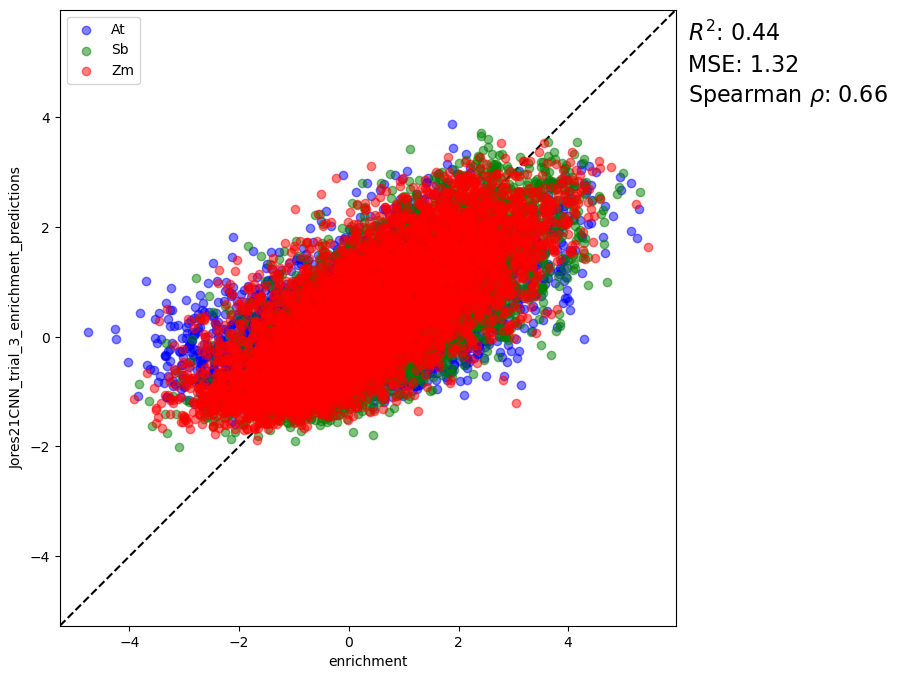

In [17]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = eu.pl.performance_scatter(
    sdata_combined, 
    targets="enrichment", 
    predictions=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(eu.settings.figure_dir, "combined_best_model_performance_scatter_by_sp.pdf")
)

In [18]:
# Save the performance summary as a table
combined_model_scores.to_csv(os.path.join(eu.settings.output_dir, "combined_performance_summary.tsv"), sep="\t")

# Performance summary table

In [19]:
# Combined everything into one dataframe
leaf_model_scores["model"] = "leaf"
proto_model_scores["model"] = "proto"
combined_model_scores["model"] = "combined"
merged_model_scores = pd.concat([leaf_model_scores, proto_model_scores, combined_model_scores])
merged_model_scores.to_csv(os.path.join(eu.settings.output_dir, "merged_performance_summary.tsv"), sep="\t")

# Cleaner seq track logos

In [134]:
# Set-up model
model = "combined"
trial = 3
model_type = "Jores21CNN"

In [135]:
# Load in importances
sdata_interpretations = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, f"{model}_test_predictions_and_interpretations.h5sd"))

In [138]:
# Grab the highest predicted seqs for the best model
top5 = sdata_interpretations[f"{model_type}_trial_{trial}_enrichment_predictions"].sort_values(ascending=False).iloc[:5].index
top5_idx = np.argsort(sdata_interpretations[f"{model_type}_trial_{trial}_enrichment_predictions"].values)[::-1][:5]

In [139]:
# Find the ranges in each seq where the model gives high interpretations
seq_num, seq_pos = np.where(np.sum(sdata_interpretations.uns["DeepLift_imps"][top5_idx], axis=1) > 0.2)
ranges = []
for j in range(5):
    curr_pos = seq_pos[np.where(seq_num == j)]
    start = curr_pos[0]
    motifs = []
    for i in range(1, len(curr_pos)):
        if curr_pos[i] - curr_pos[i-1] > 3:
            start = curr_pos[i]
            if curr_pos[i] - start > 4:
                    motifs.append((start, curr_pos[i]))
    if curr_pos[-1] - start > 4:
        motifs.append((start, curr_pos[-1]))
    ranges.append(motifs)

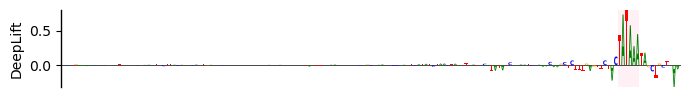

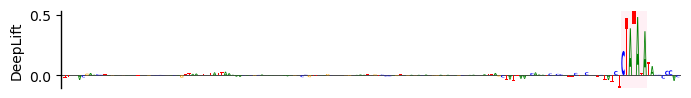

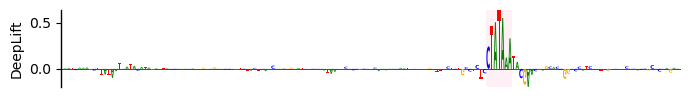

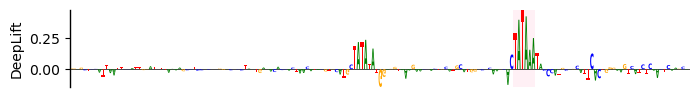

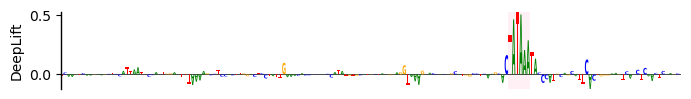

In [140]:
for i in range(5):
    eu.pl.lm_seq_track(
        sdata_interpretations,
        seq_id=top5[i],
        uns_key="DeepLift_imps",
        ylabel="DeepLift",
        highlights=ranges[i],
        figsize=(8, 1),
        save=os.path.join(eu.settings.figure_dir, f"{model}_best_model_feature_attr_{i+1}.pdf"),
    )

# TomTom annotation analysis

In [141]:
# Which model?
model = "combined"
trial = 3
model_type = "Jores21CNN"

In [142]:
# Grab and combine the results from annotating CPEs and TF clusters
tomtom_cpe = pd.read_csv(os.path.join(eu.settings.output_dir, f"{model}_best_model_filters_tomtom_CPE.tsv"), sep="\t")
tomtom_tf = pd.read_csv(os.path.join(eu.settings.output_dir, f"{model}_best_model_filters_tomtom_TF.tsv"), sep="\t")
tomtom_df = pd.concat([tomtom_cpe, tomtom_tf], axis=0)

In [143]:
# Save as a dataframe
tomtom_df.to_csv(os.path.join(eu.settings.output_dir, f"{model}_best_model_filters_tomtom.tsv"), sep="\t")

In [144]:
# Subset to significant hits
tomtom_sig = tomtom_df[tomtom_df["q-value"] <= 0.05]

In [145]:
# Add the filter number as a column
tomtom_sig["filter_num"] = tomtom_sig["Query_ID"].str.split("filter").str[-1].astype(int)

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [146]:
# Separate into filters that were instantiated and those that were purely learned
tomtom_sig_init = tomtom_sig[tomtom_sig["filter_num"] <= 77]
tomtom_sig_learned = tomtom_sig[tomtom_sig["filter_num"] > 77]

In [147]:
# How many of the original filters returned significant hits?
len(tomtom_sig_init["Target_ID"].unique())

21

In [148]:
# Separate the instantiated filters into CPE and TF hits
tomtom_sig_init_tf = tomtom_sig_init[tomtom_sig_init["Target_ID"].str.contains("TF")]
tomtom_sig_init_cpe = tomtom_sig_init[(tomtom_sig_init["Target_ID"].str.contains("TF") == False)]

In [149]:
# Get the cluster numbers for the TF hits
tomtom_sig_init_tf["TF_cluster_number"] = tomtom_sig_init_tf["Target_ID"].str.split("_").str[-1]
tomtom_sig_init_tf["TF_cluster_number"] = tomtom_sig_init_tf["TF_cluster_number"].astype(int)

In [150]:
# See how many of the initialized TF clusters remained significant to their initialization
(tomtom_sig_init_tf["TF_cluster_number"] + 5 == tomtom_sig_init_tf["filter_num"]).sum()

8

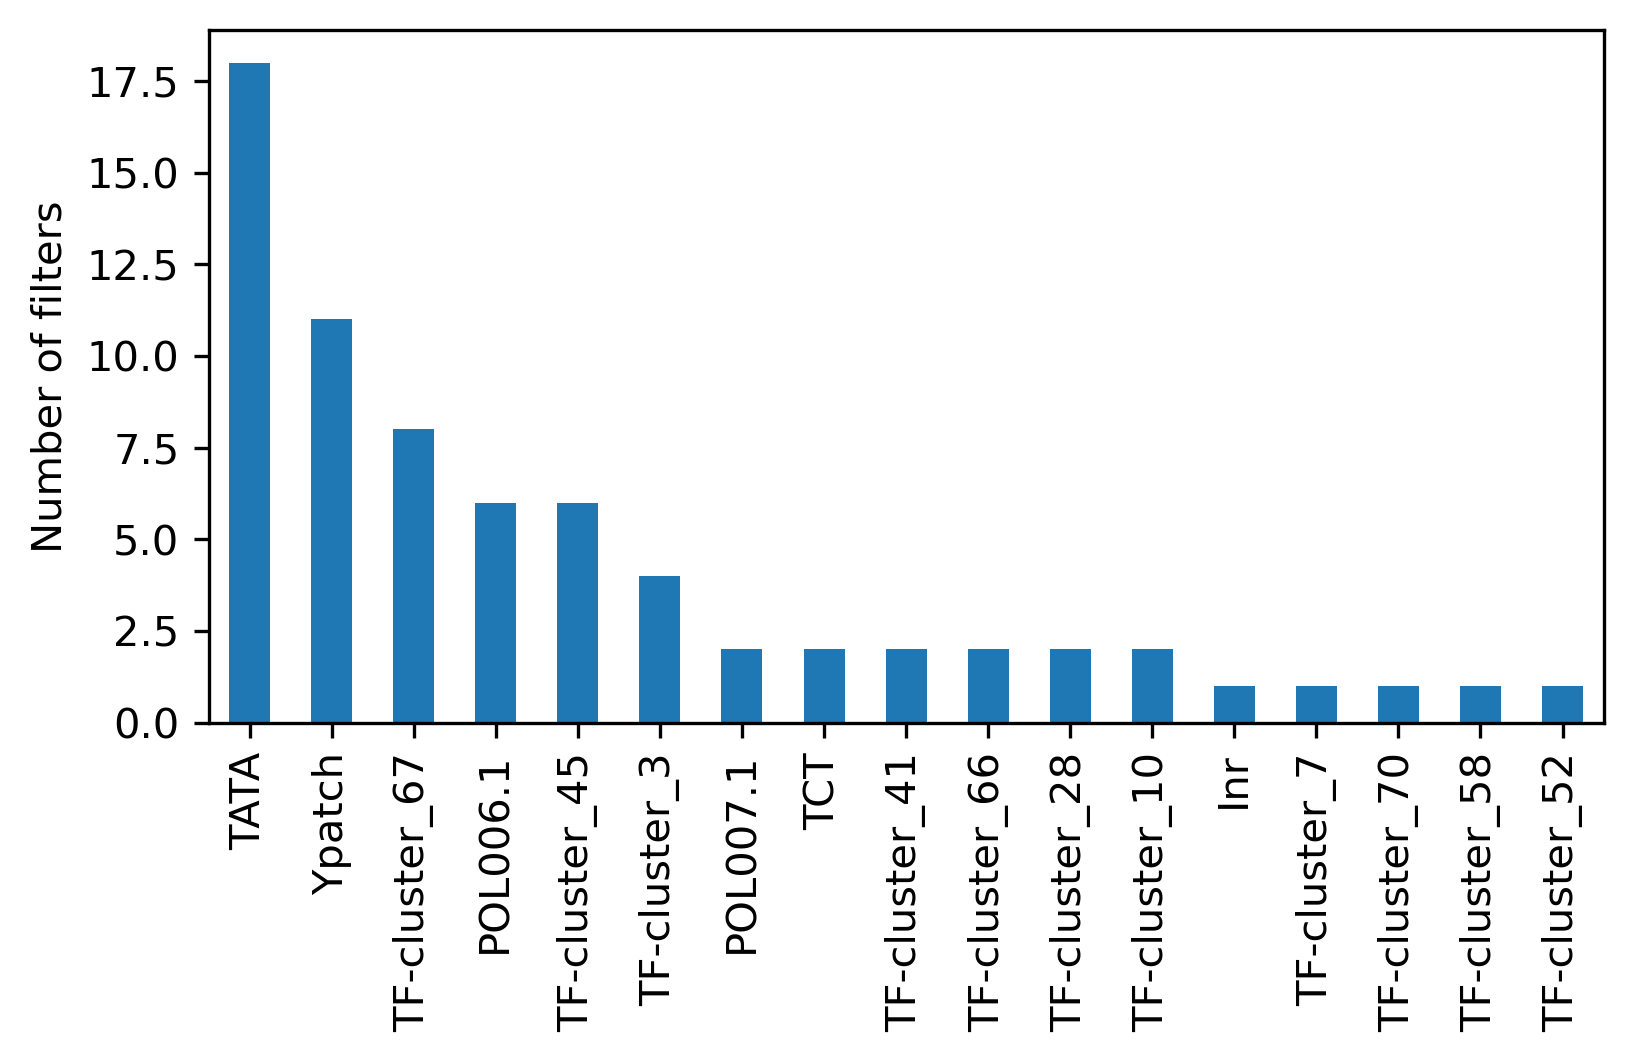

In [151]:
# Plot the frequencies of hits to motifs in the learned filters
plt.figure(figsize=(6, 3), dpi=300)
tomtom_sig_learned["Target_ID"].value_counts().plot(kind="bar", ylabel="Number of filters")
plt.savefig(os.path.join(eu.settings.figure_dir, f"{model}_best_model_filters_tomtom_barplot.pdf"))

In [152]:
# Get the most significant hits to each motif
top_tomtom_sig_learned = tomtom_sig_learned.sort_values("q-value").groupby("Target_ID").head(1)
top_tomtom_sig_learned.to_csv(os.path.join(eu.settings.output_dir, f"{model}_best_model_filters_tomtom_top_hits.tsv"), sep="\t")

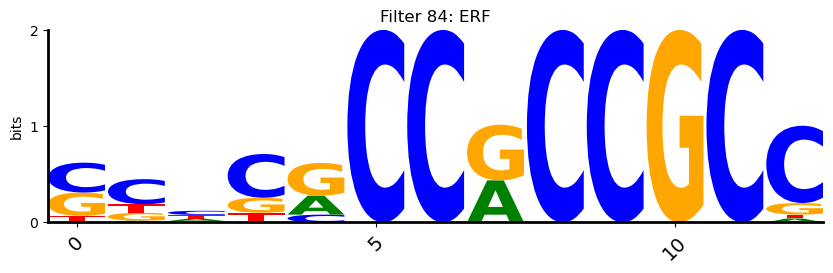

In [109]:
# Visualize a filter of choice
filter_num = 84
hit_name = "ERF"
eu.pl.lm_filter_viz(
    sdata_interpretations,
    filter_id=filter_num,
    save=os.path.join(eu.settings.figure_dir, "leaf", f"leaf_best_model_filter{filter_num}_viz.pdf"),
    title=f"Filter {filter_num}: {hit_name}",
)

In [8]:
# Save as a dataframe
merged_df = pd.DataFrame()
for model in ["leaf", "proto", "combined"]:
    x = pd.read_csv(os.path.join(eu.settings.output_dir, model, f"{model}_best_model_filters_tomtom.tsv"), sep="\t", comment="#", index_col=0)
    x["system"] = model
    merged_df = pd.concat([merged_df, x])

In [10]:
merged_df = merged_df[~merged_df["Query_ID"].isna()]

In [13]:
merged_df.to_csv(os.path.join(eu.settings.output_dir, "best_models_filters_tomtom.tsv"), sep="\t", index=False)

# Loss curve

In [153]:
# Which model?
model = "combined"
trial = 3
model_type = "Jores21CNN"

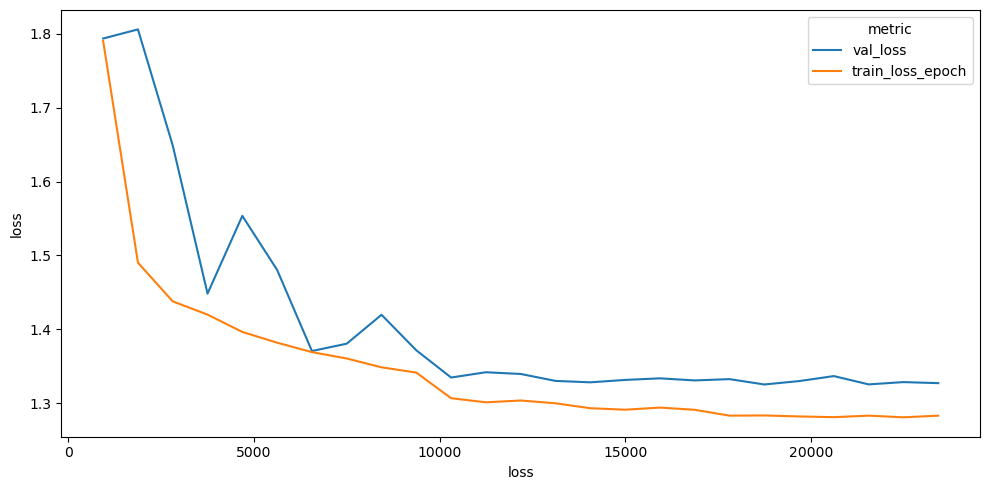

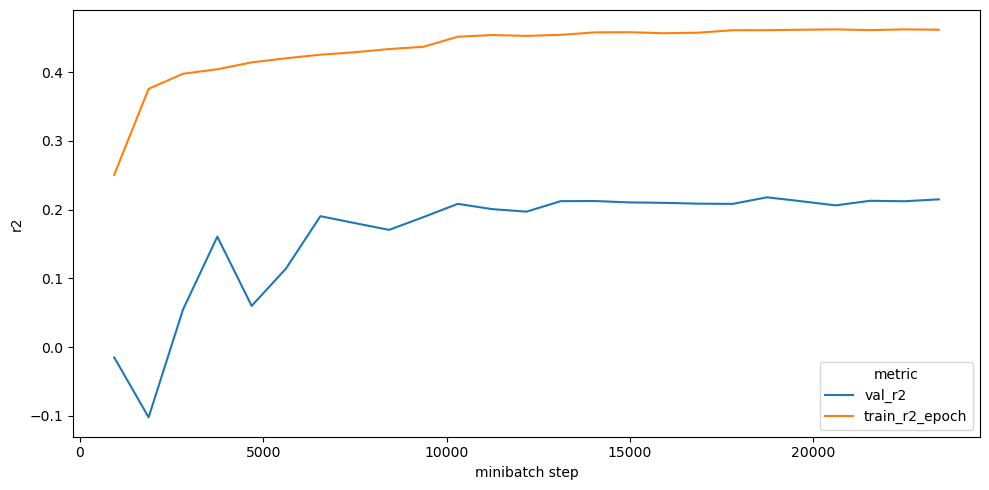

<Figure size 640x480 with 0 Axes>

In [154]:
# Plot and save the training and metric curves
eu.pl.training_summary(
    os.path.join(eu.settings.logging_dir, model_type, f"{model}_trial_{trial}"),
    metrics="r2",
    save=os.path.join(eu.settings.figure_dir, f"{model}_best_model_training_summary.pdf")
)

---